<a href="https://colab.research.google.com/github/RamMohan112/Assignement_J/blob/master/Solution_Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split

# Get Data From Google Drive

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!mkdir new_dir


In [4]:
temp_path = os.path.join("/content/new_dir","temp/")
temp_path
os.mkdir(temp_path) 

In [5]:
!cp -r "/content/drive/My Drive/Colab Notebooks/Solution_IIT_Jodhpur/charts.zip" new_dir

In [6]:
base_dir = os.path.join('/content/new_dir/')

local_zip = os.path.join(base_dir,'charts.zip')

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall(os.path.join(base_dir,'temp'))

In [7]:
train_dir = os.path.join(base_dir + 'temp/charts/train_val/')   ## Replace With Path of Directory Containing Training Images
train_csv = os.path.join(base_dir + 'temp/charts/train_val.csv') ## Replace With Path of CSV File for  Training Images
train_val_data = pd.read_csv(train_csv, dtype=str)

# Process the data

In [8]:
train_val_data.head()

,image_index,type
0,0,vbar_categorical
1,1,vbar_categorical
2,2,vbar_categorical
3,3,vbar_categorical
4,4,vbar_categorical


In [9]:
## To check the height and width of the image before any transformation
from PIL import Image
test_dir = os.path.join(base_dir + 'temp/charts/test/')
img_path = os.path.join(train_dir, '0.png')
im = Image.open(img_path)
width, height = im.size

print(f"Image height={height} width={width}")

Image height=128 width=128


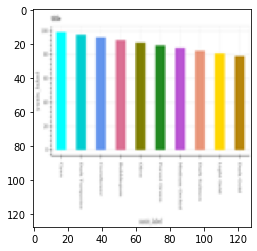

In [10]:
##Display an image

plt.imshow(im)
plt.show()

In [11]:
## Rough check if image is grayscale or rgb
from PIL import Image

def is_grey_scale(img_path):

  img = Image.open(img_path).convert('RGB')
  w,h = img.size
  for i in range(w):
      for j in range(h):
          r,g,b = img.getpixel((i,j))
          if r != g != b: return False
  return True

In [12]:
is_grey_scale(img_path) ## Means not a greyscale image

False

In [13]:
## Append Extension Name to every item in the dataframe column

def append_ext(fn):
    return fn+".png"

train_val_data["image_index"]=train_val_data["image_index"].apply(append_ext)

In [14]:
train_val_data.head()

,image_index,type
0,0.png,vbar_categorical
1,1.png,vbar_categorical
2,2.png,vbar_categorical
3,3.png,vbar_categorical
4,4.png,vbar_categorical


### Split Data for All Classes Equally in Training and Validation

In [15]:
labels = np.unique(train_val_data['type']).tolist()
labels

['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical']

In [16]:
## To select all samples conatining one label
train_val_data.loc[train_val_data['type'] == 'dot_line']

,image_index,type
800,800.png,dot_line
801,801.png,dot_line
802,802.png,dot_line
803,803.png,dot_line
804,804.png,dot_line
...,...,...
995,995.png,dot_line
996,996.png,dot_line
997,997.png,dot_line
998,998.png,dot_line


In [17]:
## Splitting Training And Validation Data for each class to have a balanced distribution

train_l = []
val_l = []


for i in labels:
  
  temp_df = train_val_data.loc[train_val_data['type'] == i].copy()

  train_class, val_class = train_test_split(temp_df, test_size=0.2, train_size=0.8, random_state=42)
  

  print(f"temp_df = {temp_df.shape} \t train_class = {train_class.shape}  \t val_class = {val_class.shape}")

  train_l.append(train_class)
  val_l.append(val_class)


  
  


temp_df = (200, 2) 	 train_class = (160, 2)  	 val_class = (40, 2)
temp_df = (200, 2) 	 train_class = (160, 2)  	 val_class = (40, 2)
temp_df = (200, 2) 	 train_class = (160, 2)  	 val_class = (40, 2)
temp_df = (200, 2) 	 train_class = (160, 2)  	 val_class = (40, 2)
temp_df = (200, 2) 	 train_class = (160, 2)  	 val_class = (40, 2)


In [18]:
train_df = pd.concat(train_l)
val_df = pd.concat(val_l)

print(f"Final Shapes - Train data={train_df.shape}  Val data={val_df.shape} ")

Final Shapes - Train data=(800, 2)  Val data=(200, 2) 


#Creating Data Pipeline

In [19]:
datagen=ImageDataGenerator(rescale=1./255.)

In [41]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="image_index",
y_col="type",
batch_size=20,
shuffle = True,
target_size=(128, 128),
seed = 42,
class_mode="categorical"
)

Found 800 validated image filenames belonging to 5 classes.


In [42]:
validation_generator=datagen.flow_from_dataframe(
dataframe=val_df,
directory=train_dir,
x_col="image_index",
y_col="type",
batch_size=20,
target_size=(128, 128),
seed = 42,
class_mode="categorical"
)

Found 200 validated image filenames belonging to 5 classes.


Label = [[0. 1. 0. 0. 0.]]


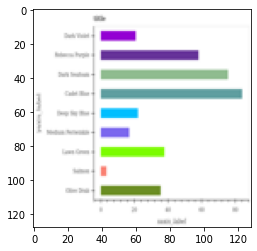

In [22]:
#Generating an image after transofrmation

temp_x = train_generator._get_batches_of_transformed_samples([200])[0]       # choosing only data point at index 1
temp_y = train_generator._get_batches_of_transformed_samples([200])[1]

plt.imshow(temp_x[0])

print("Label = {}".format(temp_y))


In [23]:
temp_x[0].shape

(128, 128, 3)

# Create Model

## 2 Layer Convolution Model Part 1

**Asssumption** - I have assumed that you by a 2 Layer CNN you meant there can only be 2 layers of CNN along with a few other layers.

In [24]:
conv_model_1 = tf.keras.models.Sequential([
                                         tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
                                         tf.keras.layers.MaxPooling2D((2, 2)),
                                         tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
                                         tf.keras.layers.MaxPooling2D((2, 2)),
                                         tf.keras.layers.Flatten(),
                                         tf.keras.layers.Dense(64, activation='relu'),
                                         tf.keras.layers.Dense(5, activation='softmax')
                                         
])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = 'm1_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False,
                             mode='auto')

In [26]:
conv_model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history_conv = conv_model_1.fit(train_generator, validation_data=validation_generator, epochs=60, callbacks=[checkpoint])

Epoch 1/60
40/40 [==============================] - 2s 38ms/step - loss: 1.6547 - accuracy: 0.2925 - val_loss: 1.5476 - val_accuracy: 0.3400
Epoch 2/60
40/40 [==============================] - 1s 33ms/step - loss: 1.4821 - accuracy: 0.3525 - val_loss: 1.3930 - val_accuracy: 0.4000
Epoch 3/60
40/40 [==============================] - 1s 34ms/step - loss: 1.2498 - accuracy: 0.5663 - val_loss: 1.1716 - val_accuracy: 0.5550
Epoch 4/60
40/40 [==============================] - 1s 35ms/step - loss: 1.0203 - accuracy: 0.6625 - val_loss: 0.8759 - val_accuracy: 0.7200
Epoch 5/60
40/40 [==============================] - 1s 34ms/step - loss: 0.7532 - accuracy: 0.7825 - val_loss: 0.6886 - val_accuracy: 0.7700
Epoch 6/60
40/40 [==============================] - 1s 33ms/step - loss: 0.6100 - accuracy: 0.8000 - val_loss: 0.5077 - val_accuracy: 0.7850
Epoch 7/60
40/40 [==============================] - 1s 34ms/step - loss: 0.4454 - accuracy: 0.8550 - val_loss: 0.4313 - val_accuracy: 0.8250
Epoch 8/60
40

In [29]:
conv_model_1 = tf.keras.models.load_model(filepath)

Text(0.5, 1.0, 'Training and validation loss')

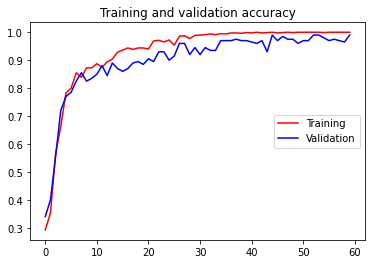

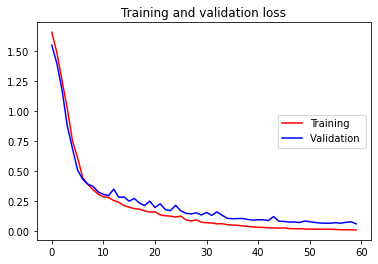

In [30]:
##PLots

acc=history_conv.history['accuracy']
val_acc=history_conv.history['val_accuracy']
loss=history_conv.history['loss']
val_loss=history_conv.history['val_loss']

epochs=range(len(acc))


# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r',label='Training')
plt.plot(epochs, val_acc, 'b',label='Validation')
plt.title('Training and validation accuracy')
plt.legend(loc='right')
plt.figure()



# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation ')
plt.legend(loc='right')
plt.title('Training and validation loss')

In [32]:
## Loss and Accuracy on Train Set
results = conv_model_1.evaluate(train_generator, verbose=0)
loss = results[0]
accuracy = results[1]

print(f" For Training loss = {loss},  acc = {accuracy}")

results_2 = conv_model_1.evaluate(validation_generator, verbose=0)
loss_2 = results_2[0]
accuracy_2 = results_2[1]

print(f" For Validation  loss = {loss_2},  acc = {accuracy_2}")

 For Training loss = 0.011456828564405441,  acc = 1.0
 For Validation  loss = 0.0611279122531414,  acc = 0.9900000095367432


## For Evaluation On Test Side

**Assumption** - That the test.csv has similar format and same name for columns and all the images are of .png format as is the case for training and validation data

In [ ]:
test_dir = ''   ## Enter Path to directory containing test images   
test_csv = ''   ## Enter Path to csv file for test image labels
test_val_data = pd.read_csv(test_csv, dtype=str)

In [ ]:
## Append Extension Name to every item in the dataframe column

test_val_data["image_index"]=test_val_data["image_index"].apply(append_ext)

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe=test_val_data,
directory=test_dir,
x_col="image_index",
y_col="type",
batch_size=20,
target_size=(128, 128),
seed = 42,
class_mode="categorical"
)

In [ ]:
results_3 = conv_model_1.evaluate(test_generator, verbose=0)
loss_3 = results_3[0]
accuracy_3 = results_3[1]

print(f" For Testing  loss = {loss_3},  acc = {accuracy_3}")

## 2 Layer Convolution Model Part 2
 **Assumption** - If my assumption for 2 Layer CNN was wrong in Part 1 then for this part I would assume that there can only be 2 layers in the model.

In [33]:
conv_model_2 = tf.keras.models.Sequential([
                                         tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
                                         tf.keras.layers.MaxPooling2D((2, 2)),
                                         tf.keras.layers.Flatten(),
                                         tf.keras.layers.Dense(5, activation='softmax')
                                         
])

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = 'm2_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False,
                             mode='auto')

In [36]:
conv_model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
history_conv = conv_model_2.fit(train_generator, validation_data=validation_generator, epochs=60, callbacks=[checkpoint])

Epoch 1/60
40/40 [==============================] - 1s 32ms/step - loss: 1.5491 - accuracy: 0.3500 - val_loss: 1.3234 - val_accuracy: 0.5700
Epoch 2/60
40/40 [==============================] - 1s 29ms/step - loss: 1.0711 - accuracy: 0.7312 - val_loss: 0.9236 - val_accuracy: 0.6850
Epoch 3/60
40/40 [==============================] - 1s 31ms/step - loss: 0.7527 - accuracy: 0.7775 - val_loss: 0.6839 - val_accuracy: 0.7600
Epoch 4/60
40/40 [==============================] - 1s 31ms/step - loss: 0.6020 - accuracy: 0.8025 - val_loss: 0.4954 - val_accuracy: 0.8550
Epoch 5/60
40/40 [==============================] - 1s 31ms/step - loss: 0.4074 - accuracy: 0.8925 - val_loss: 0.4273 - val_accuracy: 0.8150
Epoch 6/60
40/40 [==============================] - 1s 31ms/step - loss: 0.3461 - accuracy: 0.8863 - val_loss: 0.4946 - val_accuracy: 0.7950
Epoch 7/60
40/40 [==============================] - 1s 31ms/step - loss: 0.3270 - accuracy: 0.8863 - val_loss: 0.3718 - val_accuracy: 0.8300
Epoch 8/60
40

In [38]:
conv_model_2 = tf.keras.models.load_model(filepath)

Text(0.5, 1.0, 'Training and validation loss')

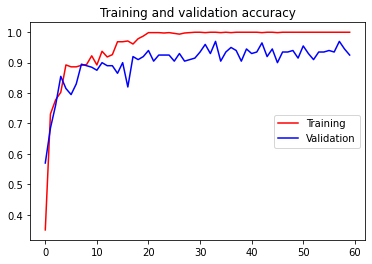

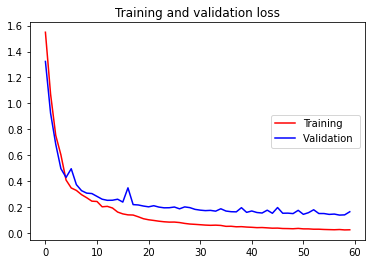

In [39]:
##PLots

acc=history_conv.history['accuracy']
val_acc=history_conv.history['val_accuracy']
loss=history_conv.history['loss']
val_loss=history_conv.history['val_loss']

epochs=range(len(acc))


# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r',label='Training')
plt.plot(epochs, val_acc, 'b',label='Validation')
plt.title('Training and validation accuracy')
plt.legend(loc='right')
plt.figure()



# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation ')
plt.legend(loc='right')
plt.title('Training and validation loss')

In [40]:
## Loss and Accuracy on Train Set
results = conv_model_2.evaluate(train_generator, verbose=0)
loss = results[0]
accuracy = results[1]

print(f" For Training loss = {loss},  acc = {accuracy}")

results_2 = conv_model_2.evaluate(validation_generator, verbose=0)
loss_2 = results_2[0]
accuracy_2 = results_2[1]

print(f" For Validation  loss = {loss_2},  acc = {accuracy_2}")

 For Training loss = 0.023551354184746742,  acc = 1.0
 For Validation  loss = 0.13628897070884705,  acc = 0.9700000286102295


## Simple Dense Model

Just For Comparison

In [ ]:
dense_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(5, activation=tf.nn.softmax)])

In [ ]:
dense_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_dense = dense_model.fit(train_generator, validation_data=validation_generator , epochs=40)

Epoch 1/40
40/40 [==============================] - 1s 28ms/step - loss: 2.5595 - accuracy: 0.2875 - val_loss: 1.2932 - val_accuracy: 0.4050
Epoch 2/40
40/40 [==============================] - 1s 26ms/step - loss: 1.2749 - accuracy: 0.4950 - val_loss: 0.7628 - val_accuracy: 0.6900
Epoch 3/40
40/40 [==============================] - 1s 25ms/step - loss: 0.7407 - accuracy: 0.6850 - val_loss: 0.6415 - val_accuracy: 0.7350
Epoch 4/40
40/40 [==============================] - 1s 25ms/step - loss: 0.9603 - accuracy: 0.7188 - val_loss: 0.8602 - val_accuracy: 0.6950
Epoch 5/40
40/40 [==============================] - 1s 25ms/step - loss: 0.6477 - accuracy: 0.7275 - val_loss: 0.4730 - val_accuracy: 0.7850
Epoch 6/40
40/40 [==============================] - 1s 25ms/step - loss: 0.5216 - accuracy: 0.7600 - val_loss: 0.7066 - val_accuracy: 0.7000
Epoch 7/40
40/40 [==============================] - 1s 25ms/step - loss: 0.6320 - accuracy: 0.7312 - val_loss: 0.9495 - val_accuracy: 0.7850
Epoch 8/40
40

Text(0.5, 1.0, 'Training and validation loss')

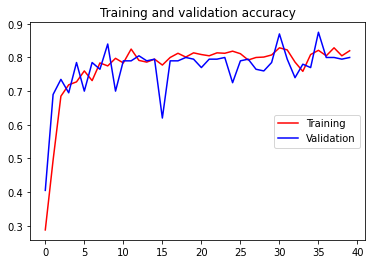

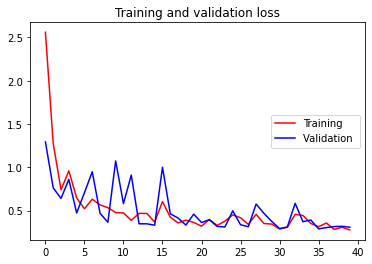

In [ ]:
##PLots

acc=history_dense.history['accuracy']
val_acc=history_dense.history['val_accuracy']
loss=history_dense.history['loss']
val_loss=history_dense.history['val_loss']

epochs=range(len(acc))


# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r',label='Training')
plt.plot(epochs, val_acc, 'b',label='Validation')
plt.title('Training and validation accuracy')
plt.legend(loc='right')
plt.figure()



# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation ')
plt.legend(loc='right')
plt.title('Training and validation loss')

In [ ]:
## Loss and Accuracy on Train Set
results = dense_model.evaluate(train_generator)
loss = results[0]
accuracy = results[1]

print(f" For Training loss = {loss},  acc = {accuracy}")

results_2 = dense_model.evaluate(validation_generator)
loss_2 = results_2[0]
accuracy_2 = results_2[1]

print(f" For Validation  loss = {loss_2},  acc = {accuracy_2}")

40/40 [==============================] - 1s 17ms/step - loss: 0.2947 - accuracy: 0.7975
 For Training loss = 0.29473793506622314,  acc = 0.7975000143051147
10/10 [==============================] - 0s 16ms/step - loss: 0.3092 - accuracy: 0.8000
 For Validation  loss = 0.3091883957386017,  acc = 0.800000011920929


## PreTrained Model

In [ ]:
IMG_SIZE, N_CHANNELS = (128, 128), 3

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0],IMG_SIZE[1], N_CHANNELS))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16.trainable = False 

In [ ]:
pre_model = tf.keras.models.Sequential()
pre_model.add(vgg16)
pre_model.add(tf.keras.layers.Flatten())
pre_model.add(tf.keras.layers.Dense(64, activation='relu'))
pre_model.add(tf.keras.layers.Dense(5, activation='softmax'))


In [ ]:
pre_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_pre = pre_model.fit(train_generator, validation_data=validation_generator , epochs=40)

Epoch 1/40
40/40 [==============================] - 2s 56ms/step - loss: 0.6550 - accuracy: 0.8487 - val_loss: 0.1606 - val_accuracy: 0.9900
Epoch 2/40
40/40 [==============================] - 2s 52ms/step - loss: 0.0881 - accuracy: 0.9975 - val_loss: 0.0598 - val_accuracy: 0.9900
Epoch 3/40
40/40 [==============================] - 2s 51ms/step - loss: 0.0383 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9900
Epoch 4/40
40/40 [==============================] - 2s 51ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 0.9950
Epoch 5/40
40/40 [==============================] - 2s 52ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9900
Epoch 6/40
40/40 [==============================] - 2s 52ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 0.9950
Epoch 7/40
40/40 [==============================] - 2s 52ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 0.9900
Epoch 8/40
40

Text(0.5, 1.0, 'Training and validation loss')

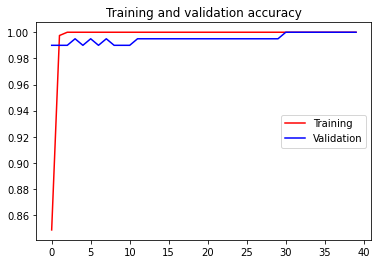

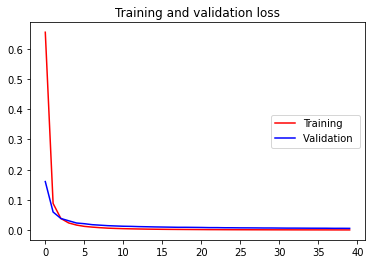

In [ ]:
##PLots

acc=history_pre.history['accuracy']
val_acc=history_pre.history['val_accuracy']
loss=history_pre.history['loss']
val_loss=history_pre.history['val_loss']

epochs=range(len(acc))


# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r',label='Training')
plt.plot(epochs, val_acc, 'b',label='Validation')
plt.title('Training and validation accuracy')
plt.legend(loc='right')
plt.figure()



# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation ')
plt.legend(loc='right')
plt.title('Training and validation loss')

In [ ]:
## Loss and Accuracy on Train Set
results = pre_model.evaluate(train_generator)
loss = results[0]
accuracy = results[1]

print(f" For Training loss = {loss},  acc = {accuracy}")

results_2 = pre_model.evaluate(validation_generator)
loss_2 = results_2[0]
accuracy_2 = results_2[1]

print(f" For Validation  loss = {loss_2},  acc = {accuracy_2}")

40/40 [==============================] - 2s 41ms/step - loss: 4.9577e-04 - accuracy: 1.0000
 For Training loss = 0.0004957708879373968,  acc = 1.0
10/10 [==============================] - 0s 37ms/step - loss: 0.0057 - accuracy: 1.0000
 For Validation  loss = 0.005677958019077778,  acc = 1.0
